# Downsize_raw_volume
This notebook was used as a sandbox to try to figure out how to resample a 3d volume to lower resolution in z for Jess' c-Fos data. 

In [1]:
import numpy as np
import SimpleITK as sitk
from scipy.ndimage import zoom
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path_to_registered_volume = '/home/ahoag/ngdemo/data/kelly_result.1.tif' # registered to PMA

In [ ]:
registered_vol = np.array(sitk.GetArrayFromImage(sitk.ReadImage(path_to_registered_volume)),
            dtype=np.uint16,order='F')

In [ ]:
registered_vol.shape

In [ ]:
z_dim,y_dim,x_dim = registered_vol.shape

In [ ]:
registered_vol[0].shape

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(registered_vol[200])

In [ ]:
resampled_vol = zoom(registered_vol, (0.1, 1, 1))

In [ ]:
resampled_vol.shape

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(resampled_vol[20])

In [ ]:
from cloudvolume import CloudVolume
allen_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/allenatlas/')

In [ ]:
allen_data = np.transpose(allen_vol[:][...,0],(2,1,0))

In [ ]:
allen_data.shape

In [ ]:
resampled_data = np.zeros([46,528,320])

In [ ]:
subvol=allen_data[0:10]

In [ ]:
medvol=np.median(subvol,axis=0)

In [ ]:
medvol.shape

In [ ]:
subvol.shape

In [ ]:
for z_out in range(46):
    print(f"Plane {z_out}")
    starting_index=z_out*10
    ending_index=starting_index+10
    avg_z_plane = np.median(allen_data[starting_index:ending_index],axis=0)
    resampled_data[z_out] = avg_z_plane

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(resampled_data[20],vmin=0,vmax=1000)

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(allen_data[200],vmin=0,vmax=1000)

In [46]:
from cloudvolume import CloudVolume
import numpy as np
import math
import os
from concurrent.futures import ProcessPoolExecutor


In [21]:
data_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawdata_an21',parallel=8)

In [22]:
rawdata_an21 = np.transpose(data_vol[:][...,0],(2,1,0))

Downloading: 1534it [00:06, 173.25it/s]                        
Downloading: 1532it [00:06, 153.80it/s]                        
Downloading: 1540it [00:07, 167.60it/s]                        
Downloading: 1520it [00:07, 152.18it/s]                        
Downloading: 1534it [00:07, 169.69it/s]                        
Downloading: 1538it [00:07, 169.50it/s]                        
Downloading: 1536it [00:07, 170.22it/s]                        
Downloading: 1544it [00:07, 180.90it/s]                        


In [78]:
first_z_plane=np.transpose(data_vol[:,:,150:155][...,0],(2,1,0))

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]








In [79]:
first_z_plane.shape

(5, 2560, 2160)

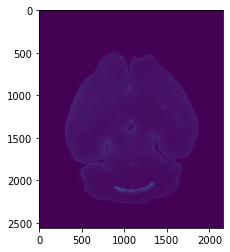

In [80]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(first_z_plane[4])

In [68]:
rawdata_an21.shape

(687, 2560, 2160)

In [5]:
cell_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawcells_an21_dilated',parallel=8)

In [6]:
rawcells_an21 = np.transpose(cell_vol[:][...,0],(2,1,0))

Downloading: 1528it [00:03, 293.06it/s]                        
Downloading: 1540it [00:03, 237.93it/s]                        
Downloading: 1532it [00:03, 322.02it/s]                        
Downloading: 1522it [00:04, 275.76it/s]                        

Downloading: 1512it [00:04, 280.80it/s]                        
Downloading: 1536it [00:04, 228.44it/s]                        
Downloading: 1512it [00:04, 267.50it/s]                        


## Downsize in parallel 

In [23]:
# First figure out how many z planes will be in the final stack
orig_shape=rawdata_an21.shape
z_dim_orig = orig_shape[0]
y_dim = orig_shape[1]
x_dim = orig_shape[2]
orig_shape

(687, 2560, 2160)

In [43]:
resample_factor_z = 5
assert type(resample_factor_z) == int
z_dim = math.ceil(z_dim_orig/5.)
z_dim

138

In [29]:
data_vol.resolution

Vec(5000,5000,10000, dtype=int64)

In [35]:
x_res,y_res,z_res_orig=data_vol.resolution

In [36]:
z_res=z_res_orig*resample_factor_z
z_res

50000

In [17]:
progress_dir = '/home/ahoag/ngdemo/progress_dirs/progress_downsample_an21'

In [18]:
def make_info_file(volume_size,resolution,layer_dir,commit=True):
    """ 
    ---PURPOSE---
    Make the cloudvolume info file.
    ---INPUT---
    volume_size     [Nx,Ny,Nz] in voxels, e.g. [2160,2560,1271]
    pix_scale_nm    [size of x pix in nm,size of y pix in nm,size of z pix in nm], e.g. [5000,5000,10000]
    commit          if True, will write the info/provenance file to disk. 
                    if False, just creates it in memory
    """
    info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'image', # 'image' or 'segmentation'
        data_type = 'uint16', # 
        encoding = 'raw', # other options: 'jpeg', 'compressed_segmentation' (req. uint32 or uint64)
        resolution = resolution, # Size of X,Y,Z pixels in nanometers, 
        voxel_offset = [ 0, 0, 0 ], # values X,Y,Z values in voxels
        chunk_size = [ 1024,1024,1 ], # rechunk of image X,Y,Z in voxels -- only used for downsampling task I think
        volume_size = volume_size, # X,Y,Z size in voxels
        )

    vol = CloudVolume(f'file://{layer_dir}', info=info)
    vol.provenance.description = "Test on spock for profiling precomputed creation"
    vol.provenance.owners = ['ahoag@princeton.edu'] # list of contact email addresses
    if commit:
        vol.commit_info() # generates info json file
        vol.commit_provenance() # generates provenance json file
        print("Created CloudVolume info file: ",vol.info_cloudpath)
    return vol

In [38]:
# Make info file for downsized layer
layer_dir = '/home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawdata_an21_downsized'
vol = make_info_file(volume_size=(x_dim,y_dim,z_dim),
                     resolution=(x_res,y_res,z_res),layer_dir=layer_dir)

Created CloudVolume info file:  file:///home/ahoag/ngdemo/demo_bucket/201904_ymaze_cfos/rawdata_an21_downsized/info


In [62]:
vol.scale['size']

[2160, 2560, 138]

In [81]:
# define the function to do a single median stack
def collapse_z(z_out):
    """ Median stack"""
    print(f"Plane {z_out}")
    starting_index=z_out*resample_factor_z
    ending_index=starting_index+resample_factor_z
    print(f"Slicing from {starting_index} to {ending_index}")
#     array = np.array(np.median(rawdata_an21[starting_index:ending_index],axis=0),
#                            dtype=np.uint16,order='F')
#     array = array.reshape((1, y_dim, x_dim)).T
#     print(array.shape)
#     vol[:,:, z_out] = array
    vol_slice = np.transpose(data_vol[:,:,starting_index:ending_index][...,0],(2,1,0))
    array = np.array(np.median(vol_slice,axis=0),
                           dtype=np.uint16,order='F')
    array = array.reshape((1, y_dim, x_dim)).T
    print(array.shape)
    vol[:,:, z_out] = array
    return "success"

In [83]:
# define the function to do cell collapse - uses amax instead of median 
def collapse_cells(z_out):
    """ Median stack"""
    print(f"Plane {z_out}")
    starting_index=z_out*resample_factor_z
    ending_index=starting_index+resample_factor_z
    print(f"Slicing from {starting_index} to {ending_index}")
#     array = np.array(np.median(rawdata_an21[starting_index:ending_index],axis=0),
#                            dtype=np.uint16,order='F')
#     array = array.reshape((1, y_dim, x_dim)).T
#     print(array.shape)
#     vol[:,:, z_out] = array
    vol_slice = np.transpose(rawcells_an21[:,:,starting_index:ending_index][...,0],(2,1,0))
    array = np.array(np.amax(vol_slice,axis=0),
                           dtype=np.uint16,order='F')
    array = array.reshape((1, y_dim, x_dim)).T
    print(array.shape)
    vol[:,:, z_out] = array
    return "success"

In [82]:
done_files = set([ int(z) for z in os.listdir(progress_dir)])
all_files = set(range(vol.bounds.minpt.z,vol.bounds.maxpt.z))
to_upload = [ int(z) for z in list(all_files.difference(done_files)) ]
to_upload.sort()

with ProcessPoolExecutor(max_workers=8) as executor:
    for job in executor.map(collapse_z,to_upload):
        try:
            print(job)
        except Exception as exc:
            print(f'generated an exception: {exc}')

Plane 2
Plane 0
Plane 7
Plane 5
Slicing from 10 to 15
Slicing from 35 to 40
Plane 3
Plane 6
Plane 1
Slicing from 25 to 30
Plane 4
Slicing from 15 to 20
Slicing from 30 to 35
Slicing from 20 to 25
Slicing from 0 to 5
Slicing from 5 to 10


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]







Downloading:   0%|          | 0/3 [00:00<?, ?it/s]





















(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s].54it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 286.69it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)




Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s].85it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s].90it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 

Plane 8
Slicing from 40 to 45


Uploading:   0%|          | 0/1 [00:00<?, ?it/s].36it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.6

Plane 9
Slicing from 45 to 50






Uploading: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Plane 10
Slicing from 50 to 55
Plane 11


Plane 12


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

Slicing from 60 to 65


Slicing from 55 to 60


Plane 13


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Slicing from 65 to 70







Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

Plane 14


Slicing from 70 to 75
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



















(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

(2160, 2560, 1)


(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Plane 15
Slicing from 75 to 80




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

success
success
success
success
success
success





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploadi

Plane 16
Slicing from 80 to 85



Uploading: 100%|██████████| 1/1 [00:00<00:00, 44.16it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.11it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 27.24it/s]



Plane 17


Slicing from 85 to 90


Plane 18
Plane 19
Slicing from 95 to 100
Plane 20
Slicing from 90 to 95
Slicing from 100 to 105


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]






Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]



Plane 21
Slicing from 105 to 110









Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A


Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A



Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

Plane 22
Slicing from 110 to 115
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


success
success
success
success
success
success


Uploading: 100%|██████████| 1/1 [00:00<00:00, 839.87it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 16.00it/s]A

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]




Downloading:   0%|    

Plane 23
Slicing from 115 to 120


Plane 24
Slicing from 120 to 125







Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

Plane 25


Slicing from 125 to 130


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Plane 26
Slicing from 130 to 135


Plane 27


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

Slicing from 135 to 140


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]










Downloading:   0%|          | 0/6 [00:00<?, ?it/s]7it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]










Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

Plane 28
Slicing from 140 to 145


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)




Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]







Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/

(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:

Plane 29


Slicing from 145 to 150


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

success



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]5it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]2it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]4it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

Plane 30
Slicing from 150 to 155





Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

Plane 31


Slicing from 155 to 160


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

Plane 32
Slicing from 160 to 165


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]




Plane 33


Slicing from 165 to 170
Plane 34
Slicing from 170 to 175


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]9it/s]


success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.42it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]








Plane 35
Slicing from 175 to 180





Downloading:   0%|          | 0/3 [00:00<?, ?it/s]4it/s]



(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


Plane 36
Slicing from 180 to 185




Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]






(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

(2160, 2560, 1)
success
(2160, 2560, 1)
(2160, 2560, 1)


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]7it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|████████

(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00, 39.73it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|█████

Plane 37


Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

Slicing from 185 to 190







Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Plane 38
Plane 39
Plane 40
Plane 41
Slicing from 200 to 205
Slicing from 205 to 210
Slicing from 190 to 195
Slicing from 195 to 200


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]0it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]














(2160, 2560, 1)


Plane 42
Slicing from 210 to 215



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Plane 43
Slicing from 215 to 220








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

success
success
success


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]3it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


(2160, 2560, 1)



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

(2160, 2560, 1)






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.11it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:0

Plane 44
Plane 45
(2160, 2560, 1)
Slicing from 225 to 230
Plane 46
Slicing from 220 to 225
Slicing from 230 to 235
Plane 47
Slicing from 235 to 240
Plane 48
Slicing from 240 to 245


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]






Downloading:   0%|          | 0/3 [00:00<?, ?it/s]1it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]2it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]3it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Plane 49
Slicing from 245 to 250





Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 50
Slicing from 250 to 255
success
success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Plane 51
Slicing from 255 to 260
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

(2160, 2560, 1)


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)









Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]A





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]A


Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:0

Plane 52
Slicing from 260 to 265








Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.73it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]



Plane 53
Slicing from 265 to 270


Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]





Plane 54
Slicing from 270 to 275


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

Plane 55
Slicing from 275 to 280





Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

Plane 56


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Slicing from 280 to 285


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Plane 57


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Slicing from 285 to 290


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




(2160, 2560, 1)



Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

success
success
success
success




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]









Downloading:   0%|          | 0/6 [00:00<?, ?it/s]A



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 58
Slicing from 290 to 295



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]2it/s]




Downloading:   0%|          | 0/3 [00:00<?, ?it/s]






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]6it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

success
success







Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

(2160, 2560, 1)




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

(2160, 2560, 1)










Uploading:   0%|          | 0/1 [00:00<?, ?it/s].59it/s]

(2160, 2560, 1)
(2160, 2560, 1)



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Plane 59
Slicing from 295 to 300





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]A




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

success


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]A

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s].76it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0

Plane 60
Slicing from 300 to 305




Uploading: 100%|██████████| 1/1 [00:00<00:00, 20.03it/s]







Plane 61
Slicing from 305 to 310


Plane 62
Slicing from 310 to 315
Plane 64
Plane 63
Slicing from 315 to 320
Slicing from 320 to 325
Plane 65
Slicing from 325 to 330
Plane 66
Slicing from 330 to 335


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success
success
success
success
success



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]















Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

(2160, 2560, 1)















Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)





Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

(2160, 2560, 1)
(2160, 2560, 1)



Uploading:   0%|          | 0/1 [00:00<?, ?it/s].10it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:0

Plane 67
Slicing from 335 to 340


Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Uploading: 100%|█

Plane 68


Slicing from 340 to 345




Uploading: 100%|██████████| 1/1 [00:00<00:00, 54.86it/s]




Plane 69
Plane 70
Slicing from 345 to 350
Slicing from 350 to 355
Plane 71
Slicing from 355 to 360
Plane 72
Slicing from 360 to 365


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 74


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 73
Slicing from 365 to 370
Slicing from 370 to 375


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success
success
success
success
success
success


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]














Downloading:   0%|          | 0/6 [00:00<?, ?it/s]











(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]8.68it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.89it/s]A

Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]







Uploading:   0%|       

Plane 75


Slicing from 375 to 380


Plane 76
Plane 77
Plane 79
Plane 80
Plane 78
Slicing from 395 to 400
Slicing from 400 to 405
Slicing from 380 to 385
Slicing from 385 to 390
Slicing from 390 to 395
Plane 81
Slicing from 405 to 410
Plane 82
Slicing from 410 to 415
success
success
success
success
success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]







































(2160, 2560, 1)
(2160, 2560, 1)









Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s].63it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00





Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 22.54it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Plane 83


Slicing from 415 to 420




Uploading: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]

Plane 84


Slicing from 420 to 425


Plane 85
Slicing from 425 to 430



Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

Plane 87
Plane 86
Slicing from 435 to 440


Slicing from 430 to 435


Plane 88
Slicing from 440 to 445
Plane 89
Plane 90
Slicing from 450 to 455
Slicing from 445 to 450


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success
success
success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]










Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





























(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)




Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 1

Plane 91


Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.95it/s]

Slicing from 455 to 460








Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

Plane 92






Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Slicing from 460 to 465




Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]





Plane 93
Plane 95
Plane 96
Plane 94
Slicing from 475 to 480
Slicing from 465 to 470
Slicing from 480 to 485
Plane 97
Slicing from 485 to 490
Slicing from 470 to 475




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]8it/s]

success
success
success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]












Downloading:   0%|          | 0/6 [00:00<?, ?it/s]









Plane 98
Slicing from 490 to 495








Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00, 505.34it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading:   0%| 

Plane 99


Plane 100
Slicing from 500 to 505


Slicing from 495 to 500



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


Plane 102
Slicing from 510 to 515
Plane 101
Plane 105
Plane 103
Plane 104
Slicing from 515 to 520
Slicing from 525 to 530
Slicing from 520 to 525
Slicing from 505 to 510




Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]



Downloading:   0%|          | 0/3 [00:00<?, ?it/s]3it/s]

success
success
success
success
success
success
success



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]













Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]









Plane 106
Slicing from 530 to 535


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]





(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]A






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]A





Uploading:   0%|          | 0/9 [00:00<?, 

Plane 107


Uploading: 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

Slicing from 535 to 540




Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 32.70it/s]

Plane 108
Slicing from 540 to 545
Plane 110
Slicing from 550 to 555


Plane 109



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

Slicing from 545 to 550



Uploading: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 111
Slicing from 555 to 560
Plane 112
Slicing from 560 to 565


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]













Plane 113


Slicing from 565 to 570






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Plane 114
Slicing from 570 to 575


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



success
success
success
success
success
success
success
success


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00, 357.51it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00, 505.70it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/9 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Plane 115


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

Slicing from 575 to 580


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Plane 116
Slicing from 580 to 585


Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]9it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

Plane 117
Slicing from 585 to 590
Plane 118


Slicing from 590 to 595


Plane 119


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Slicing from 595 to 600


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]5it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]7it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]1it/s]








Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


success
success
success


Plane 120


Slicing from 600 to 605


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]




Plane 121
Slicing from 605 to 610


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Downloading:   0%|          | 0/3 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Plane 122


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Slicing from 610 to 615




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]









Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



success
success





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading: 100%|██████████| 1/1 [00:00<00:00,  

Plane 123
Slicing from 615 to 620
Plane 124
Plane 125
Slicing from 620 to 625
Slicing from 625 to 630
Plane 127
Plane 126
Slicing from 635 to 640
Slicing from 630 to 635
Plane 128



Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

Slicing from 640 to 645


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]7it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]






Downloading:   0%|          | 0/6 [00:00<?, ?it/s]





Downloading:   0%|          | 0/6 [00:00<?, ?it/s]















Plane 129
Slicing from 645 to 650



Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Plane 130
Slicing from 650 to 655


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

success
success
success
success
success
success


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/9 [00:00<?, ?it/s].06it/s]



(2160, 2560, 1)


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00, 14.91it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


(2160, 2560, 1)


Uploading: 100%|██████████| 1/1 [00:00<00:00, 59.70it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s].08it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]






Plane 131


Slicing from 655 to 660




Uploading: 100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



Plane 132
Slicing from 660 to 665
Plane 133
Slicing from 665 to 670





Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]





Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]



Uploading: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]




Uploading: 100%|██████████| 1/1 [00:00<00:00,  9.85it/s]

Plane 134



Uploading: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

Slicing from 670 to 675


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]4it/s]

Plane 135


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Slicing from 675 to 680


Plane 136


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Slicing from 680 to 685



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


success
success
success
success


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Plane 137
Slicing from 685 to 690


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]


Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading:   0%|          | 0/6 [00:00<?, ?it/s]




Downloading:   0%|          | 0/6 [00:00<?, ?it/s]



Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]











Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

success
success


Uploading: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]



(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
(2160, 2560, 1)
success
success


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/9 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

(2160, 2560, 1)




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]








Uploading:   0%|          | 0/9 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]





Uploading:   0%|          | 0/1 [00:00<?, ?it/s]






Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.32it/s]



Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]


Uploading:   0%|          | 0/1 [00:00<?, ?it/s]







Uploading:   0%|          | 0/1 [00:00<?, ?it/s]




Uploading:   

success
success
success






Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

Uploading: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


success
success
success


OutOfBoundsError: Value 690 cannot be outside of inclusive range 0 to 687

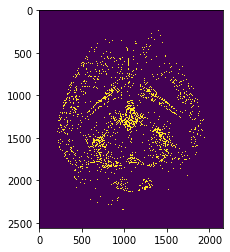

In [88]:
fig= plt.figure()
ax = fig.add_subplot(1,1,1)
cell_amax = np.amax(rawcells_an21[200:250],axis=0)
ax.imshow(cell_amax)

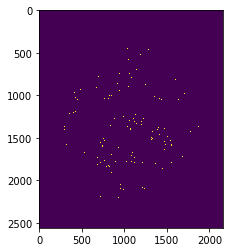

In [89]:
fig= plt.figure()
ax = fig.add_subplot(1,1,1)
cell_amax = rawcells_an21[200]
ax.imshow(cell_amax)

In [86]:
rawcells_an21[200:250].shape

(50, 2560, 2160)

In [2]:
import glob

In [3]:
sorted_files = sorted(glob.glob("/home/ahoag/ngdemo/data/*Z015*"))
sorted_files

['/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0150.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0151.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0152.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0153.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0154.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0155.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0156.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0157.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0158.tif',
 '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0159.tif']

In [20]:
x_dim = 2160
y_dim = 2560
downsize_factor_z=5
output_vol = np.zeros((2,y_dim,x_dim))

In [21]:
def process_slice(z):
    starting_index=z*downsize_factor_z
    ending_index=starting_index+downsize_factor_z
    print(f"Slicing from {starting_index} to {ending_index}")
    z_plane_files = sorted_files[starting_index:ending_index]
    print(z_plane_files)
    subvol = np.zeros((len(z_plane_files),y_dim,x_dim))
    print("Calculating median")
    for ii,img_name in enumerate(z_plane_files):
        image = Image.open(img_name)
        array = np.array(image, dtype=np.uint16, order='F')
        array = array.reshape(y_dim,x_dim)
        subvol[ii] = array      
        image.close()

    median_plane = np.array(np.median(subvol,axis=0),
                           dtype=np.uint16)
    print("Calculated median")
    output_vol[z] = median_plane
#     median_plane = median_plane.reshape((1, y_dim, x_dim)).T
#     vol[:,:, z] = median_plane
    
#     touch(os.path.join(progress_dir, str(z)))
    print("success")
    return

In [22]:
for jj in range(2):
    process_slice(jj)

Slicing from 0 to 5
['/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0150.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0151.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0152.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0153.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0154.tif']
Calculating median
Calculated median
success
Slicing from 5 to 10
['/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0155.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0156.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0157.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_020719_1d3x_647_008na_1hfds_z10um_400msec_C00_Z0158.tif', '/home/ahoag/ngdemo/data/an21_ymazefos_

In [18]:
im1 = Image.open(sorted_files[0])

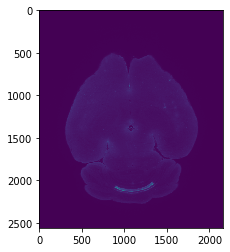

In [19]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(im1)

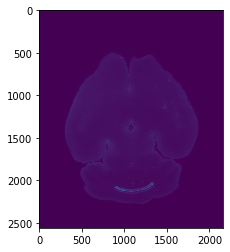

In [23]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(output_vol[0])

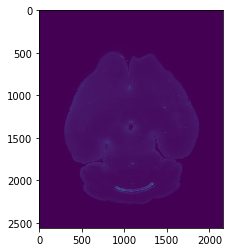

In [24]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
ax.imshow(output_vol[1])